In [2]:
import sys
sys.path.append("../../")

In [3]:
import torch
import torch.nn as nn
from src.model.ResBlock import ResBlockConv, ResBlockConvTranspose
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"


class Net(nn.Module):

    def __init__(self, args):
        super(Net, self).__init__()

        # parameters
        self.z_channels = args.z_channels
        self.z_h = args.z_h
        self.z_w = args.z_w
        self.z_dim = self.z_channels * self.z_h * self.z_w
        self.img_dim = args.img_dim
        self.batch_size = args.batch_size
        self.hidden_dim = args.hidden_dim
        self.channels = args.channels
        self.device = args.device
        
        # posterior
        self.fc1 = nn.Linear(self.z_dim, self.z_dim)
        self.fc2 = nn.Linear(self.z_dim, self.z_dim)
 
        # other
        self.relu = nn.ELU()
        self.kld_weight = 1.0 / 99.0
        
        # reconstruction loss function
        if args.recon_loss == "BCE":
            self.recon_loss = nn.BCELoss(reduction='none')
        elif args.recon_loss == "MSE":
            self.recon_loss = nn.MSELoss(reduction='none')
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(self.channels, self.hidden_dim, 4, 2, 1, bias=False), # 8x8 --> 16x16
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            #nn.Conv2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 16x16 --> 32x32
            #nn.BatchNorm2d(self.hidden_dim),
            #nn.ELU(),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 32x32 --> 64x64
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 64x64 --> 128x128
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 128x128 --> 256x256
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 256x256 --> 512x512
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            ResBlockConv(self.hidden_dim, self.hidden_dim), # 512x512 --> 512x512
            ResBlockConv(self.hidden_dim, self.hidden_dim), # 512x512 --> 512x512
            nn.Conv2d(self.hidden_dim, self.z_channels, 3, 1, 1, bias=True) # 512x512 --> 512x512
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.z_channels, self.hidden_dim, 4, 2, 1, bias=False), # 8x8 --> 16x16
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            #nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 16x16 --> 32x32
            #nn.BatchNorm2d(self.hidden_dim),
            #nn.ELU(),
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 32x32 --> 64x64
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 64x64 --> 128x128
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 128x128 --> 256x256
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            nn.ConvTranspose2d(self.hidden_dim, self.hidden_dim, 4, 2, 1, bias=False), # 256x256 --> 512x512
            nn.BatchNorm2d(self.hidden_dim),
            nn.ELU(),
            ResBlockConvTranspose(self.hidden_dim, self.hidden_dim), # 512x512 --> 512x512
            ResBlockConvTranspose(self.hidden_dim, self.hidden_dim), # 512x512 --> 512x512
            nn.ConvTranspose2d(self.hidden_dim, self.channels, 3, 1, 1, bias=True) # 512x512 --> 512x512
        )
        
        self.fc_encoder = nn.Sequential(
            nn.Linear(self.z_dim, self.z_dim),
            nn.ReLU(),
            nn.Linear(self.z_dim, self.z_dim),
            nn.ReLU(),
            nn.Linear(self.z_dim, self.z_dim)
        )
        
        self.fc_decoder = nn.Sequential(
            nn.Linear(self.z_dim, self.z_dim),
            nn.ReLU(),
            nn.Linear(self.z_dim, self.z_dim),
            nn.ReLU(),
            nn.Linear(self.z_dim, self.z_dim)
        )

    def encode(self, x):
        z = self.encoder(x)
        return z

    def decode(self, z):
        x = self.decoder(z)
        return x

    def reparameterize(self, mu, logvar, just_mean=False):
        if just_mean:
            return mu
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(logvar)
            return mu + eps * std

    def update_device(self, device):
        self.device = update_device
        
    # got the kld from the disentangled sequential autoencoder repo
    def get_kld(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1) * 100
    
    def vae_loss(self, x, x_pred, mu, logvar):
        recon = self.recon_loss(x_pred, x).sum((1, 2, 3))
        kld = self.get_kld(mu, logvar)
        return recon, kld

    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        z = torch.randn(batch_size, self.z_dim, device=self.device)
        z = self.fc_decoder(z)
        return self.decode(z.reshape(batch_size, self.z_channels, self.z_h, self.z_w))

    def forward(self, x):
        batch_size = x.size(0)
        encoded = self.encode(x)
        encoded = encoded.view(batch_size, -1)
        # fully connected after convolution
        encoded = self.fc_encoder(encoded)
        mu, logvar = self.fc1(encoded), self.fc2(encoded)
        z = self.reparameterize(mu, logvar)
        # fully connected beore conv transpose
        z = self.fc_decoder(z)
        z = z.reshape(batch_size, self.z_channels, self.z_h, self.z_w)
        x_pred = self.decode(z)
        recon, kld = self.vae_loss(x, x_pred, mu, logvar)
        return recon, kld, x_pred

In [4]:
import argparse

def parse_args():
    
    parser = argparse.ArgumentParser(description="Template")

    # anything that affects the name of the saved folders (for checkpoints, experiments, tensorboard)
    parser.add_argument('-sess', '--session_name', default="march_9_mlp4", type=str, help="session name (KG, HyperKG, HyperKG_RNN)")
    parser.add_argument('-EX', '--experiments', default='./experiments/', type=str, help="Output folder for experiments")
    parser.add_argument('-MF', '--model_folder', default='./trained_models/', type=str, help="Output folder for experiments")
    parser.add_argument('-TB', '--tensorboard_folder', default='./tb_runs/', type=str, help="Output folder for tensorboard")
    
    # model parameters
    parser.add_argument('-NG', '--decoder_channels', default=20, type=int, help="Factor for dim of channels inside decoder")
    parser.add_argument('-R', '--z_channels', default=25, type=int, help="Number of channels in r latent")
    parser.add_argument('-RW', '--z_w', default=8, type=int, help="Width of r latent")
    parser.add_argument('-RH', '--z_h', default=8, type=int, help="Height of r latent")
    parser.add_argument('-RL', '--recon_loss', default="MSE", type=str, help="Which reconstruction loss function to use (BCE, MSE)")
    parser.add_argument('-H', '--hidden_dim', default=10, type=int, help="Dimension of LSTM output")

    # training / testing
    parser.add_argument('-D', '--device', default=2, type=int, help="Which device to use")
    parser.add_argument('-E', '--epochs', default=50, type=int, help="Number of Training Epochs")
    parser.add_argument('-B', '--batch_size', default=25, type=int, help="Batch size")    
    parser.add_argument('-I', '--checkpoint_interval', default=1, type=int, help="Saves the model every checkpoint_interval intervals")
    parser.add_argument('-CL', '--clip', default=1.0, type=float, help="Gradient clip value")
    parser.add_argument('-GF', '--gamma_factor', default=0.9995, type=float, help="Learning rate decay factor")
    parser.add_argument('-C', '--load_cp', default=0, type=int, help="If 1, loads previous checkpoint")
    parser.add_argument('-lr', '--learning_rate', default=1e-3, type=float, help="Learning rate")
    parser.add_argument('-lmda', '--regularization', default=1e-4, type=float, help="L2 penalty")

    # data
    parser.add_argument('-ID', '--img_dim', default=512, type=int, help="Dimensions of the frames")
    parser.add_argument('-CH', '--channels', default=3, type=int, help="Number of channels in image frame")
    
    return parser.parse_args("") 

args = parse_args()

torch.cuda.set_device(args.device)
device = torch.cuda.current_device()

In [5]:
import matplotlib.pyplot as plt

In [6]:
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import os
import random


class LeagueDataset(Dataset):

    def __init__(self, fpath, img_dim):
        self.data = []
        
        self.transform = transforms.Compose([
            transforms.Resize((img_dim, img_dim)),  # scale imported image
            transforms.ToTensor()])  # transform it into a torch tensor
        
        for f in os.listdir(fpath):
            if ".jpg" in f:
                self.data.append(self.load_image(fpath + f).numpy())
        
        self.data = torch.from_numpy(np.array(self.data)).squeeze()
        #self.data = (self.data - torch.mean(self.data, dim=0)) / torch.std(self.data, dim=0)
        the_min = torch.min(self.data, dim=0)[0]
        the_max = torch.max(self.data, dim=0)[0]
        self.data = (self.data - the_min) / (the_max - the_min)

    def load_image(self, fname):
        image = Image.open(fname)
        # fake batch dimension required to fit network's input dimensions
        image = self.transform(image).unsqueeze(0)
        return image.to(torch.float)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
dataset = LeagueDataset("../../data/", 256)

In [8]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

In [9]:
net = Net(args).to(device)

In [10]:
optim = torch.optim.Adam(net.parameters(), lr=args.learning_rate)

In [11]:
net.train()
for epoch in range(500):
    print("EPOCH " + (str(epoch)))
    recon, kld = 0, 0
    for _, x in enumerate(dataloader): 
        x = x.to(device).type(torch.float)
        curr_recon, curr_kld, _ = net(x)
        recon += curr_recon.sum()
        kld += curr_kld.sum()
        loss = (curr_recon + curr_kld).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
    print('        recon : ' + str(recon.item() / len(dataset)))
    print('        kld   : '+ str(kld.item() / len(dataset)))

EPOCH 0
        recon : 170107.26380368098
        kld   : 2063.4018404907974
EPOCH 1
        recon : 69281.76073619632
        kld   : 56.004751006518404
EPOCH 2
        recon : 38820.407975460126
        kld   : 36.34824638132669
EPOCH 3
        recon : 26423.60736196319
        kld   : 12.392603587519172
EPOCH 4
        recon : 20794.207055214723
        kld   : 9.666955491516488
EPOCH 5
        recon : 17761.286809815952
        kld   : 2.4923567508627302
EPOCH 6
        recon : 16034.276073619632
        kld   : 0.824199746722824
EPOCH 7
        recon : 14934.423312883435
        kld   : 0.4207030688326783
EPOCH 8
        recon : 14271.895705521472
        kld   : 0.25894478639942003
EPOCH 9
        recon : 13811.875766871166
        kld   : 0.18909160637416722
EPOCH 10
        recon : 13483.955521472393
        kld   : 0.14387994309875862
EPOCH 11
        recon : 13230.449386503067
        kld   : 0.11240346007551884
EPOCH 12
        recon : 13018.777607361963
        kld   : 0.1

        recon : 10163.378834355828
        kld   : 232.01076016104295
EPOCH 106
        recon : 10031.041411042945
        kld   : 335.82220571319016
EPOCH 107
        recon : 10085.657208588957
        kld   : 268.1452262269939
EPOCH 108
        recon : 10158.65644171779
        kld   : 308.31899444018404
EPOCH 109
        recon : 10171.603527607362
        kld   : 345.88144651073617
EPOCH 110
        recon : 10036.306748466257
        kld   : 255.28891871165644
EPOCH 111
        recon : 10098.802914110429
        kld   : 344.21582630368096
EPOCH 112
        recon : 10083.597392638037
        kld   : 254.26222200920245
EPOCH 113
        recon : 10380.683282208589
        kld   : 253.51188650306747
EPOCH 114
        recon : 10033.00690184049
        kld   : 291.24606978527606
EPOCH 115
        recon : 10092.749233128834
        kld   : 238.76706288343559
EPOCH 116
        recon : 10080.00690184049
        kld   : 295.93618194018404
EPOCH 117
        recon : 10197.216257668711
        k

        recon : 9981.842791411043
        kld   : 404.55995973926383
EPOCH 211
        recon : 9749.08282208589
        kld   : 314.2917944785276
EPOCH 212
        recon : 10042.749233128834
        kld   : 282.18860237730064
EPOCH 213
        recon : 9810.103527607362
        kld   : 301.0488640720859
EPOCH 214
        recon : 9957.992331288344
        kld   : 279.51131134969324
EPOCH 215
        recon : 10034.556748466257
        kld   : 323.5121021855828
EPOCH 216
        recon : 9764.986196319018
        kld   : 346.5430885736196
EPOCH 217
        recon : 9904.210889570551
        kld   : 246.61014187116564
EPOCH 218
        recon : 9841.65644171779
        kld   : 309.2036761886503
EPOCH 219
        recon : 10057.309049079755
        kld   : 288.6922210506135
EPOCH 220
        recon : 9869.226993865032
        kld   : 372.61196319018404
EPOCH 221
        recon : 9830.03680981595
        kld   : 343.89728719325154
EPOCH 222
        recon : 9760.4754601227
        kld   : 311.320911

        recon : 9724.80981595092
        kld   : 314.8914877300613
EPOCH 316
        recon : 9772.345858895706
        kld   : 308.8942436733129
EPOCH 317
        recon : 9870.617331288344
        kld   : 305.0269123849693
EPOCH 318
        recon : 9763.916411042945
        kld   : 315.5034269555215
EPOCH 319
        recon : 9873.953987730061
        kld   : 321.2588190184049
EPOCH 320
        recon : 9800.88036809816
        kld   : 275.36330521472394
EPOCH 321
        recon : 9691.812116564417
        kld   : 360.0308665644172
EPOCH 322
        recon : 9585.305214723927
        kld   : 315.22507668711654
EPOCH 323
        recon : 9841.812883435583
        kld   : 257.90241564417175
EPOCH 324
        recon : 9810.023006134968
        kld   : 276.2032208588957
EPOCH 325
        recon : 9740.603527607362
        kld   : 307.6823236196319
EPOCH 326
        recon : 9659.192484662577
        kld   : 339.9627588190184
EPOCH 327
        recon : 9786.208588957055
        kld   : 294.806101418

        recon : 11725.444018404907
        kld   : 2.34144896441966e+26
EPOCH 420
        recon : 11505.204754601227
        kld   : 2.2216786253298562e+27
EPOCH 421
        recon : 11627.143404907976
        kld   : 9.033852960911605e+22
EPOCH 422
        recon : 11618.187116564417
        kld   : 8.467461066675848e+27
EPOCH 423
        recon : 11659.976993865032
        kld   : 1.0313806300616137e+30
EPOCH 424
        recon : 11597.148773006134
        kld   : 3.133604213240907e+26
EPOCH 425
        recon : 11560.498466257668
        kld   : 1.5678286853563677e+27
EPOCH 426
        recon : 11632.31518404908
        kld   : 1.0631526820914694e+27
EPOCH 427
        recon : 11494.674846625767
        kld   : 9.978683163351578e+29
EPOCH 428
        recon : 11489.053680981595
        kld   : 9.316438726176333e+26
EPOCH 429
        recon : 11498.64417177914
        kld   : 6.12573003501645e+27
EPOCH 430
        recon : 11527.411042944785
        kld   : 4.174263620605536e+28
EPOCH 431
    

KeyboardInterrupt: 

In [11]:
torch.save(net, "net_march14.pt")

In [12]:
net = net.to(device).eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


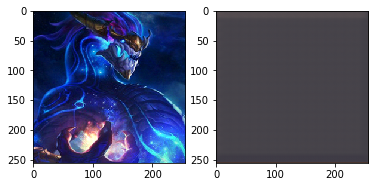

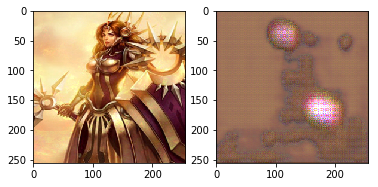

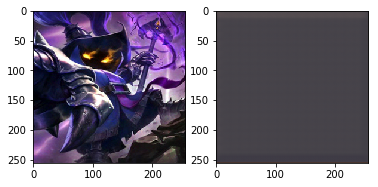

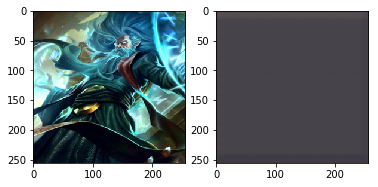

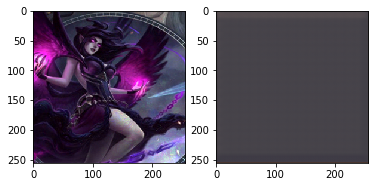

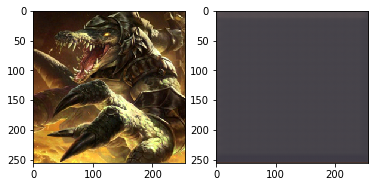

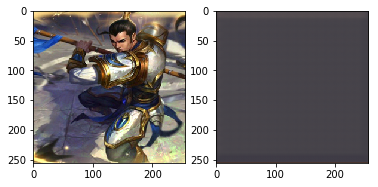

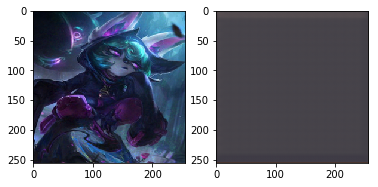

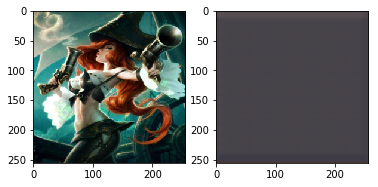

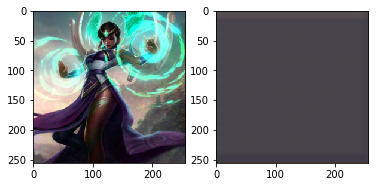

In [12]:
x = next(iter(dataloader)).to(device)
_, _, x_pred = net(x)

for i in range(10):
    fig, axes = plt.subplots(1, 2)
    curr = x[i]
    curr = torch.transpose(curr, 0, 1)
    curr = torch.transpose(curr, 1, 2)
    curr = curr.cpu().detach().numpy()
    axes[0].imshow(curr)

    curr = x_pred[i]
    curr = torch.transpose(curr, 0, 1)
    curr = torch.transpose(curr, 1, 2)
    curr = curr.cpu().detach().numpy()
    axes[1].imshow(curr)
plt.show()

In [14]:
#torch.cuda.set_device(3)
#device = torch.cuda.current_device()
#net = net.to(device).eval()

In [15]:
#z = torch.randn(args.batch_size, args.z_dim, device=device)
#x_sample = net.decode(z)

In [16]:
net = torch.load("net_march14.pt").to(device).eval()

In [16]:
x_sample = net.sample(batch_size=10)

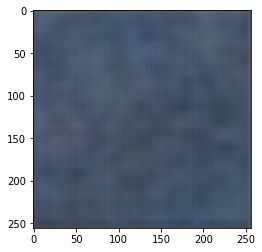

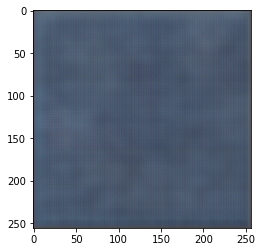

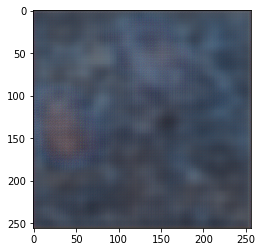

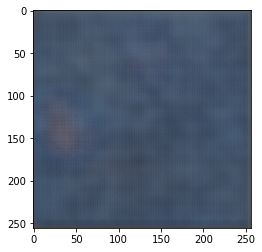

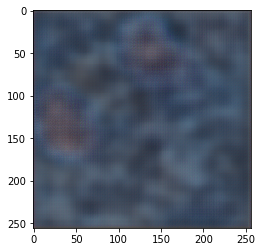

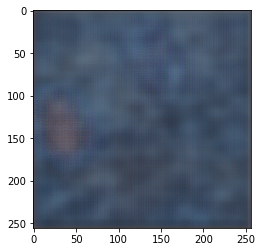

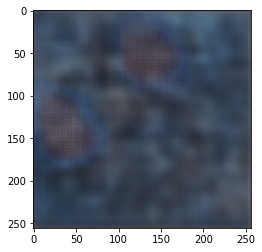

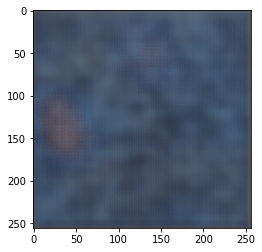

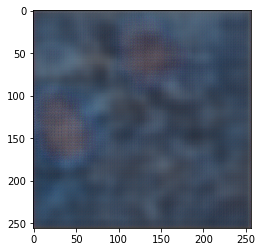

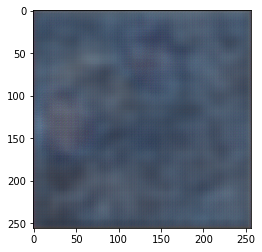

In [17]:
for i in range(10):
    curr = x_sample[i]
    curr = torch.transpose(curr, 0, 1)
    curr = torch.transpose(curr, 1, 2)
    curr = curr.cpu().detach().numpy()
    plt.imshow(curr)
    plt.show()